This notebook gives a fairly complicated example of building a Sankey diagram from the sample "fruit" database. Other examples (TODO) break this process down into simpler stages.

In [1]:
from sankeyview import *
from sankeyview.jupyter import show_sankey, show_view_graph
from IPython.display import SVG

Load the dataset:

In [2]:
dataset = Dataset.from_csv('fruit_flows.csv', 'fruit_processes.csv')

This made-up dataset describes flows from farms to consumers:

In [3]:
dataset._flows.head()

,source,target,material,time,value
0,farm1,eat1,apples,2011-08-01,2.720691
1,eat1,landfill Cambridge,apples,2011-08-01,1.904484
2,eat1,composting Cambridge,apples,2011-08-01,0.816207
3,farm1,eat1,apples,2011-08-02,8.802195
4,eat1,landfill Cambridge,apples,2011-08-02,6.161537


Additional information is available in the process dimension table:

In [4]:
dataset._processes.head()

,type,location,function,sector
id,,,,
inputs,stock,*,inputs,NaN
farm1,process,Cambridge,small farm,farming
farm2,process,Cambridge,small farm,farming
farm3,process,Ely,small farm,farming
farm4,process,Ely,allotment,farming


We'll also define some partitions that will be useful:

In [5]:
farm_ids = ['farm{}'.format(i) for i in range(1, 16)]

farm_partition_5 = Partition.Simple('process', [('Other farms', farm_ids[5:])] + farm_ids[:5])
partition_fruit = Partition.Simple('material', ['bananas', 'apples', 'oranges'])
partition_sector = Partition.Simple('process.sector', ['government', 'industry', 'domestic'])

Now define the Sankey diagram definition.

- Process groups represent sets of processes in the underlying database. The underlying processes can be specified as a list of ids (e.g. `['inputs']`) or as a Pandas query expression (e.g. `'function == "landfill"'`).
- Waypoints allow extra control over the partitioning and placement of flows.

In [6]:
nodes = {
    'inputs':     ProcessGroup(['inputs'], title='Other inputs'),
    'compost':    ProcessGroup('function == "composting stock"', title='Compost'),
    'farms':      ProcessGroup('function in ["allotment", "large farm", "small farm"]', farm_partition_5),
    'eat':        ProcessGroup('function == "consumers" and location != "London"', partition_sector,
                               title='consumers by sector'),
    'landfill':   ProcessGroup('function == "landfill" and location != "London"', title='Landfill'),
    'composting': ProcessGroup('function == "composting process" and location != "London"', title='Composting'),

    'fruit':        Waypoint(partition_fruit, title='fruit type'),
    'w1':           Waypoint(direction='L', title=''),
    'w2':           Waypoint(direction='L', title=''),
    'export fruit': Waypoint(Partition.Simple('material', ['apples', 'bananas', 'oranges'])),
    'exports':      Waypoint(title='Exports'),
}

The ordering defines how the process groups and waypoints are arranged in the final diagram. It is structured as a list of vertical *layers* (from left to right), each containing a list of horizontal *bands* (from top to bottom), each containing a list of process group and waypoint ids (from top to bottom).

In [7]:
ordering = [
    [[], ['inputs', 'compost'], []],
    [[], ['farms'], ['w2']],
    [['exports'], ['fruit'], []],
    [[], ['eat'], []],
    [['export fruit'], ['landfill', 'composting'], ['w1']],
]

Bundles represent flows in the underlying database:

In [8]:
bundles = [
    Bundle('inputs', 'farms'),
    Bundle('compost', 'farms'),
    Bundle('farms', 'eat', waypoints=['fruit']),
    Bundle('farms', 'compost', waypoints=['w2']),
    Bundle('eat', 'landfill'),
    Bundle('eat', 'composting'),
    Bundle('composting', 'compost', waypoints=['w1', 'w2']),
    Bundle('farms', Elsewhere, waypoints=['exports', 'export fruit', ]),
]

Finally, the process groups, waypoints, bundles and ordering are combined into a Sankey diagram definition (SDD). When applied to the dataset, the result is a Sankey diagram!

In [9]:
sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=dataset.partition('material'))
sankey = show_sankey(sdd, dataset, width=800, height=500)
sankey

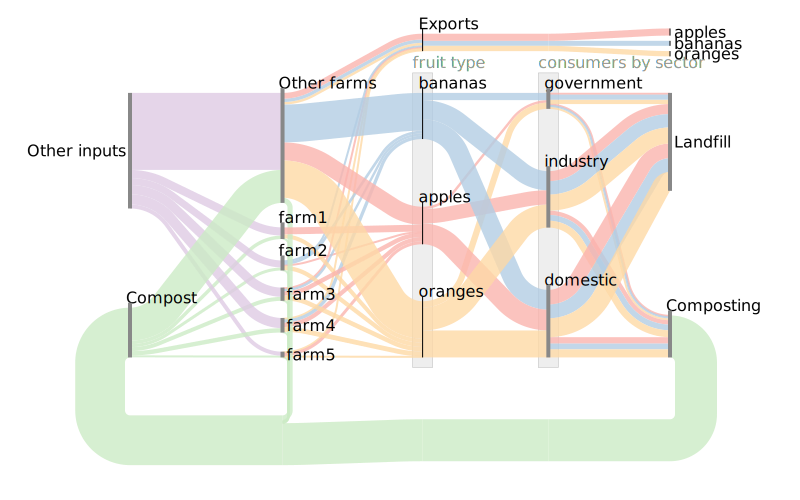

In [10]:
# For viewing on nbviewer, save a static version of the diagram
SVG(sankey.svg)

To help get a better understanding of what's going on, it may be helpful to look at the intermediate "view graph":

> This depends on graphviz being available

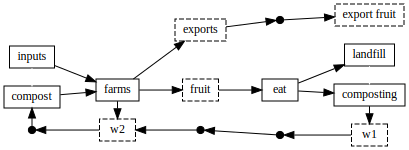

In [11]:
show_view_graph(sdd)

Waypoints are shown with dashed borders. The black dots are "dummy nodes", added so that each link in the Sankey diagram has to pass only between adjacent layers.